# Values detection + Upper line detection

In [1080]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import cv2
import math

The idea is to:
- take the lines from each frame (I have 2 points for each line per frame, so I must create the lines)
- calculate the length of the lower line
- calculate the angles between the lines
- calculate manually the length or the height of the upper line
- find some correlation between these things
- calculate manually the gradient of the lower and upper lines
- find some correlation between the difference between the two angles and the difference between the gradiens.

In [1081]:
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / "recording_3" / "Recording_3.mp4")
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "lane_lines" / "definitive_lines_3.csv")
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)

frame_index = 20

# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

df = pd.read_csv(CSV_POSITIONS_FILE_PATH)

In [1082]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [1083]:
# Function to get line endpoints extended to image edges
def get_extended_line(x1, y1, x2, y2, img_width, img_height):
    if x1 == x2:  # Vertical line
        return (x1, 0), (x2, img_height)
    else:
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1

        # Intersections with left (x=0) and right (x=img_width)
        y_at_left = int(m * 0 + b)
        y_at_right = int(m * img_width + b)

        points = []
        if 0 <= y_at_left <= img_height:
            points.append((0, y_at_left))
        if 0 <= y_at_right <= img_height:
            points.append((img_width, y_at_right))

        # Intersections with top (y=0) and bottom (y=img_height)
        if m != 0:
            x_at_top = int((0 - b) / m)
            x_at_bottom = int((img_height - b) / m)

            if 0 <= x_at_top <= img_width:
                points.append((x_at_top, 0))
            if 0 <= x_at_bottom <= img_width:
                points.append((x_at_bottom, img_height))

        # Choose two valid points
        if len(points) >= 2:
            return points[0], points[1]
        else:
            return (x1, y1), (x2, y2)  # fallback if math fails

In [ ]:
# Read the CSV with line coordinates
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)

# Extract line points for the first frame (frame index 0)
first_frame_data = df.iloc[frame_index]

# Image dimensions
height, width = frame.shape[:2]

# Extract and convert points to integer tuples
hx1, hy1, hx2, hy2 = map(int, [first_frame_data['hx1'], first_frame_data['hy1'], first_frame_data['hx2'], first_frame_data['hy2']])
lx1, ly1, lx2, ly2 = map(int, [first_frame_data['lx1'], first_frame_data['ly1'], first_frame_data['lx2'], first_frame_data['ly2']])
rx1, ry1, rx2, ry2 = map(int, [first_frame_data['rx1'], first_frame_data['ry1'], first_frame_data['rx2'], first_frame_data['ry2']])

# Draw extended lines
frame_with_lines = frame.copy()

# Horizontal
pt1, pt2 = get_extended_line(hx1, hy1, hx2, hy2, width, height)
cv2.line(frame_with_lines, pt1, pt2, (0, 255, 0), 3)

# Left
pt1, pt2 = get_extended_line(lx1, ly1, lx2, ly2, width, height)
cv2.line(frame_with_lines, pt1, pt2, (0, 255, 0), 3)

# Right
pt1, pt2 = get_extended_line(rx1, ry1, rx2, ry2, width, height)
cv2.line(frame_with_lines, pt1, pt2, (0, 255, 0), 3)

array([[[ 62,  69,  89],
        [ 62,  69,  89],
        [ 61,  68,  88],
        ...,
        [ 10,  10,  56],
        [ 10,  10,  56],
        [ 10,  10,  56]],

       [[ 62,  69,  89],
        [ 62,  69,  89],
        [ 61,  68,  88],
        ...,
        [ 10,  10,  56],
        [ 10,  10,  56],
        [ 10,  10,  56]],

       [[ 62,  69,  89],
        [ 62,  69,  89],
        [ 61,  68,  88],
        ...,
        [ 10,   9,  58],
        [ 10,   9,  58],
        [ 10,   9,  58]],

       ...,

       [[ 75,  96, 122],
        [ 75,  96, 122],
        [ 75,  96, 122],
        ...,
        [ 79,  94, 124],
        [ 79,  94, 124],
        [ 79,  94, 124]],

       [[ 74,  95, 121],
        [ 74,  95, 121],
        [ 74,  95, 121],
        ...,
        [ 79,  94, 124],
        [ 79,  94, 124],
        [ 79,  94, 124]],

       [[ 74,  95, 121],
        [ 74,  95, 121],
        [ 74,  95, 121],
        ...,
        [ 79,  94, 124],
        [ 79,  94, 124],
        [ 79,  94, 124]]

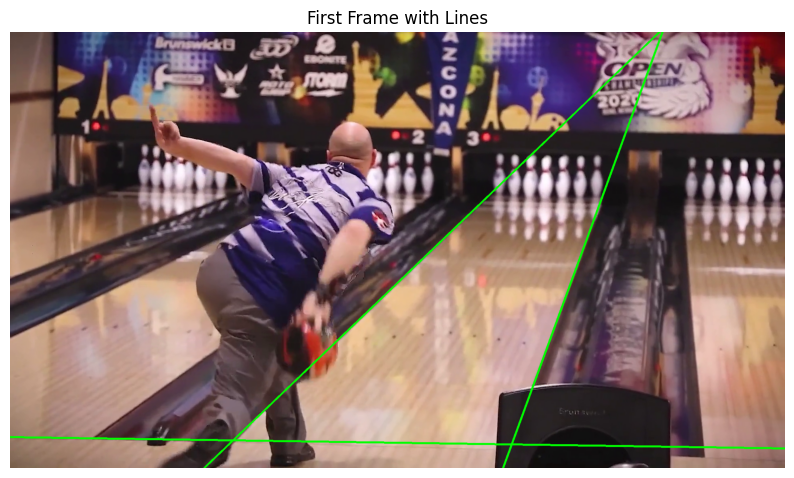

In [1085]:
showImage(frame_with_lines, "First Frame with Lines")

Now I want to take the intersection of these 3 lines

In [1086]:
# Function to get slope and intercept from two points
def get_line_eq(x1, y1, x2, y2):
    if x1 == x2:  # vertical line
        return None, x1  # Represent vertical line as (None, x) where x is the constant x-coordinate
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

In [1087]:
# Function to compute intersection between two lines
def get_intersection(m1, b1, m2, b2):
    if m1 is None and m2 is None:
        return None  # both vertical: no intersection
    elif m1 is None:
        x = b1
        y = m2 * x + b2
    elif m2 is None:
        x = b2
        y = m1 * x + b1
    elif m1 == m2:
        return None  # parallel lines
    else:
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
    return int(x), int(y)

In [1088]:
# Get line equations
m_h, b_h = get_line_eq(hx1, hy1, hx2, hy2)
m_l, b_l = get_line_eq(lx1, ly1, lx2, ly2)
m_r, b_r = get_line_eq(rx1, ry1, rx2, ry2)

# Compute intersections
intersect_hl = get_intersection(m_h, b_h, m_l, b_l)
intersect_hr = get_intersection(m_h, b_h, m_r, b_r)
intersect_lr = get_intersection(m_l, b_l, m_r, b_r)

# Draw intersections as circles
for pt in [intersect_hl, intersect_hr, intersect_lr]:
    if pt:
        cv2.circle(frame_with_lines, pt, 8, (0, 0, 255), -1)

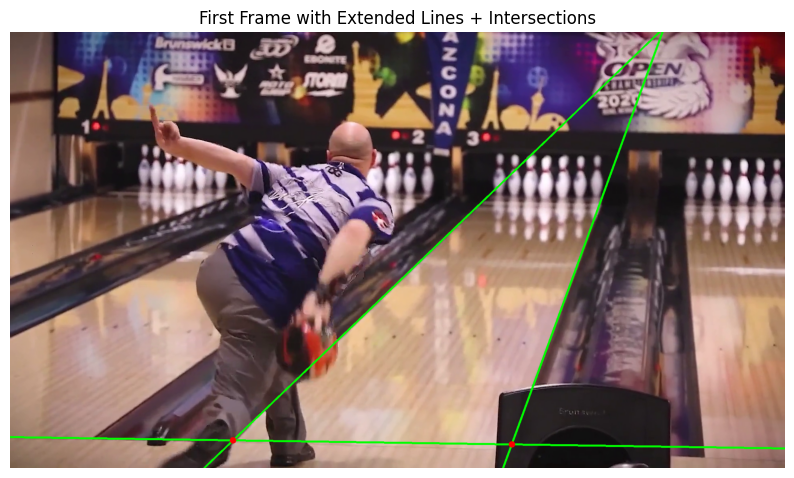

In [1089]:
showImage(frame_with_lines, "First Frame with Extended Lines + Intersections")

Now I want to take the length between the points on the horizontal line.

In [1090]:
# Ensure both points exist before calculating distance
if intersect_hl and intersect_hr:
    x1, y1 = intersect_hl
    x2, y2 = intersect_hr
    distance = math.hypot(x2 - x1, y2 - y1)
    print(f"Distance between HL and HR intersection points: {distance:.2f} pixels")
else:
    print("One or both intersection points are missing, can't calculate distance.")

Distance between HL and HR intersection points: 691.07 pixels


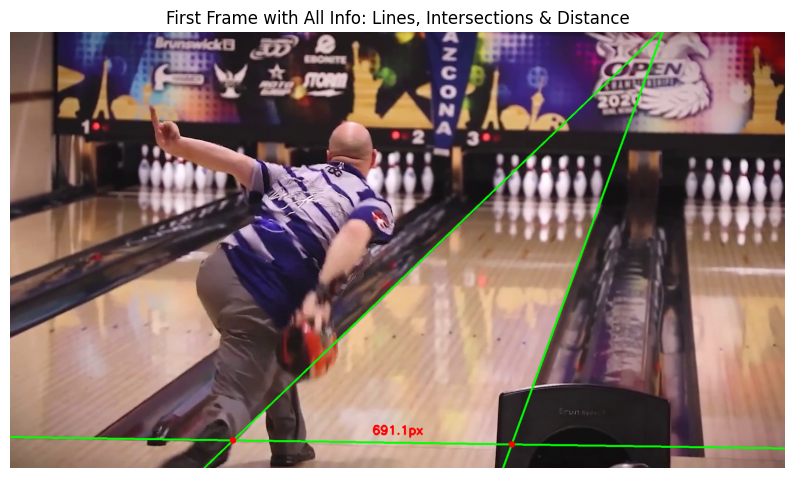

In [1091]:
# Draw angles on the image
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
color = (0, 0, 255)
thickness = 3

if intersect_hl and intersect_hr:
    # Midpoint between the two intersections
    mid_x = int((intersect_hl[0] + intersect_hr[0]) / 2)
    mid_y = int((intersect_hl[1] + intersect_hr[1]) / 2) - 20  # slightly above the midpoint

    # Draw the distance text
    cv2.putText(frame_with_lines, f"{distance:.1f}px", (mid_x, mid_y), font, font_scale, color, thickness)

showImage(frame_with_lines, "First Frame with All Info: Lines, Intersections & Distance")

Now I want to calculate the angles at the bottom

In [1092]:
# Helper to get direction vector from two points
def get_vector(x1, y1, x2, y2):
    return np.array([x2 - x1, y2 - y1])

In [1093]:
# Helper to compute angle between two vectors
def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.degrees(angle_rad)

In [1094]:
# Horizontal vector (same for both angles)
h_vec = get_vector(hx1, hy1, hx2, hy2)

# Left and Right vectors (from intersection point)
l_vec = get_vector(intersect_hl[0], intersect_hl[1], lx2, ly2)
r_vec = get_vector(intersect_hr[0], intersect_hr[1], rx2, ry2)

# Compute angles
angle_hl = angle_between(h_vec, l_vec)
angle_hr = 180 - angle_between(h_vec, r_vec)
angle_difference = angle_hr - angle_hl

print(f"Internal angle between Horizontal and Left: {angle_hl:.2f} degrees")
print(f"Internal angle between Horizontal and Right: {angle_hr:.2f} degrees")

if intersect_hl:
    cv2.putText(frame_with_lines, f"{angle_hl:.1f}deg", (intersect_hl[0] + 20, intersect_hl[1] - 20), font, font_scale, color, thickness)

if intersect_hr:
    cv2.putText(frame_with_lines, f"{angle_hr:.1f}deg", (intersect_hr[0] + 20, intersect_hr[1] - 20), font, font_scale, color, thickness)

if intersect_hl and intersect_hr:
    cv2.putText(frame_with_lines, f"Angle difference: {angle_difference:.2f}deg", (50, 50), font, font_scale, (0, 0, 255), thickness)

Internal angle between Horizontal and Left: 44.57 degrees
Internal angle between Horizontal and Right: 109.25 degrees


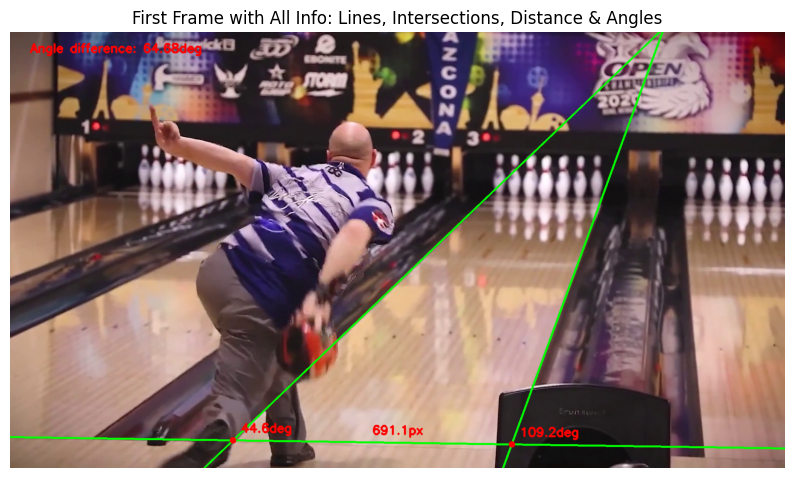

In [1095]:
showImage(frame_with_lines, "First Frame with All Info: Lines, Intersections, Distance & Angles")

Computation of the gradient of the Horizontal line

In [1096]:
# Compute the slope (gradient) of the horizontal line
if hx2 != hx1:
    slope_h = (hy2 - hy1) / (hx2 - hx1)
    print(f"Slope (gradient) of the horizontal line: {slope_h:.6f}")
else:
    print("Horizontal line is vertical — undefined slope")

Slope (gradient) of the horizontal line: 0.014515


In [1097]:
angle_h_rad = math.atan(slope_h)
angle_h_deg = math.degrees(angle_h_rad)
print(f"Inclination angle of horizontal line: {angle_h_deg:.2f}°")

Inclination angle of horizontal line: 0.83°


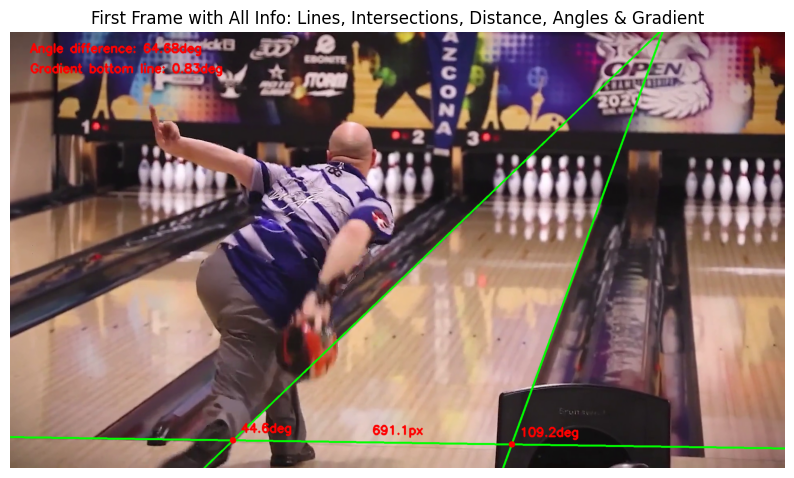

In [1098]:
cv2.putText(frame_with_lines, f"Gradient bottom line: {angle_h_deg:.2f}deg", (50, 100), font, font_scale, (0, 0, 255), thickness)

showImage(frame_with_lines, "First Frame with All Info: Lines, Intersections, Distance, Angles & Gradient")

Now I take manually the two points of the Upper line

In [1099]:
%run -i ~/projects/IACV_project/bowling-analysis/notebook/various_tests/Manual_point_acquisition.py

points = points
# "points" are returned by the invocation of Manual_points_acquisition.py
# Selected Points: [(1357, 456), (977, 451)]

Selected Points: [(1465, 418), (1182, 411)]


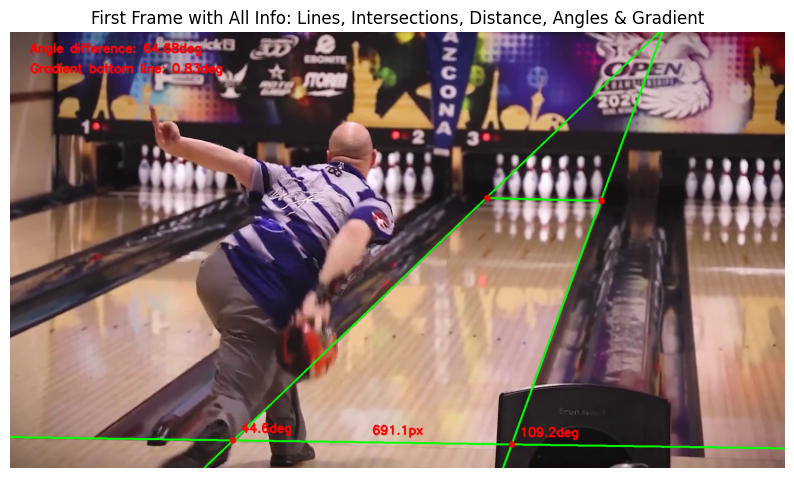

In [1100]:
if len(points) == 2:
    cv2.line(frame_with_lines, points[0], points[1], (0, 255, 0), 3)
    cv2.circle(frame_with_lines, points[0], 8, (0, 0, 255), -1)
    cv2.circle(frame_with_lines, points[1], 8, (0, 0, 255), -1)

showImage(frame_with_lines, "First Frame with All Info: Lines, Intersections, Distance, Angles & Gradient")

Calculation of the length and gradient of this new line

Distance between manual points: 283.09 pixels
Slope of manual line: 0.024735
Inclination angle of manual line: 1.42°


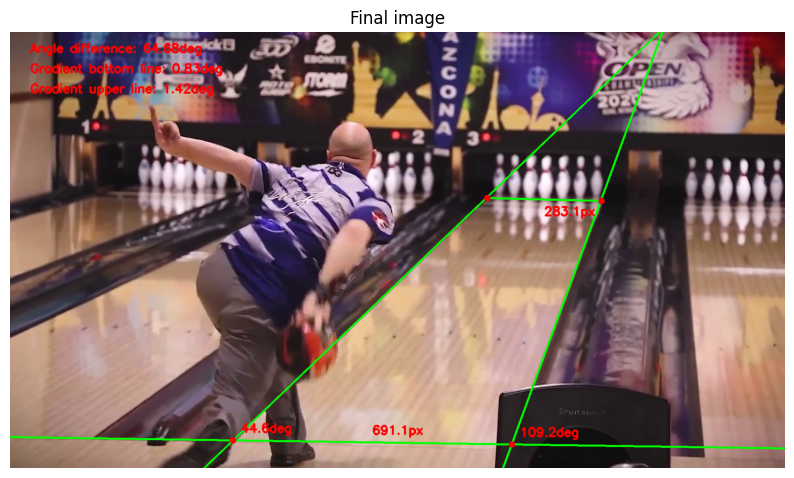

In [1101]:
# Calculate distance and gradient if we have two manual points
if len(points) == 2:
    x1, y1 = points[0]
    x2, y2 = points[1]

    # Distance
    manual_distance = math.hypot(x2 - x1, y2 - y1)
    print(f"Distance between manual points: {manual_distance:.2f} pixels")

    # Slope
    if x2 != x1:
        manual_slope = (y2 - y1) / (x2 - x1)
        manual_angle_deg = math.degrees(math.atan(manual_slope))
        print(f"Slope of manual line: {manual_slope:.6f}")
        print(f"Inclination angle of manual line: {manual_angle_deg:.2f}°")
    else:
        manual_slope = None
        manual_angle_deg = 90.0
        print("Manual line is vertical — slope undefined, angle = 90°")

    # Display distance and angle on the image
    mid_x = int((x1 + x2) / 2)
    mid_y = int((y1 + y2) / 2) + 40

    cv2.putText(frame_with_lines, f"{manual_distance:.1f}px", (mid_x, mid_y), font, font_scale, (0, 0, 255), thickness)
    cv2.putText(frame_with_lines, f"Gradient upper line: {manual_angle_deg:.2f}deg", (50, 150), font, font_scale, (0, 0, 255), thickness)

showImage(frame_with_lines, "Final image")

Now that I have calculated all these data I need the distance between the upper and bottom line

Distance between midpoints of bottom and upper lines: 737.48 pixels


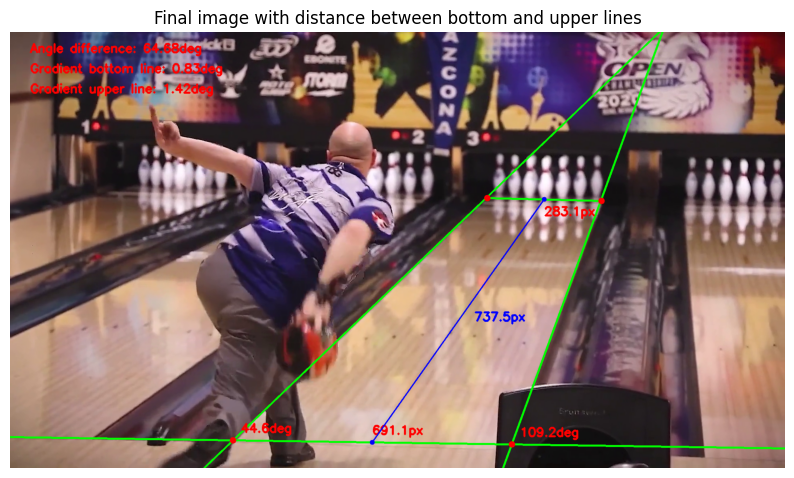

In [1102]:
# Ensure we have the required points
if intersect_hl and intersect_hr and len(points) == 2:
    # Midpoint of intersections (already used earlier)
    mid_intersections = (
        int((intersect_hl[0] + intersect_hr[0]) / 2),
        int((intersect_hl[1] + intersect_hr[1]) / 2)
    )

    # Midpoint of manual line
    x1, y1 = points[0]
    x2, y2 = points[1]
    mid_manual = (
        int((x1 + x2) / 2),
        int((y1 + y2) / 2)
    )

    # Distance between midpoints
    dx = mid_manual[0] - mid_intersections[0]
    dy = mid_manual[1] - mid_intersections[1]
    midpoint_distance = math.hypot(dx, dy)

    print(f"Distance between midpoints of bottom and upper lines: {midpoint_distance:.2f} pixels")

    # Draw it on the image
    mid_text_x = int((mid_manual[0] + mid_intersections[0]) / 2) + 40
    mid_text_y = int((mid_manual[1] + mid_intersections[1]) / 2)
    cv2.putText(frame_with_lines, f"{midpoint_distance:.1f}px", (mid_text_x, mid_text_y), font, font_scale, (255, 0, 0), thickness)

    # Optional: draw a line connecting the two midpoints
    cv2.line(frame_with_lines, mid_intersections, mid_manual, (255, 0, 0), 2)
    cv2.circle(frame_with_lines, mid_intersections, 6, (255, 0, 0), -1)
    cv2.circle(frame_with_lines, mid_manual, 6, (255, 0, 0), -1)

showImage(frame_with_lines, "Final image with distance between bottom and upper lines")


| Recording number  | 2    | 3    | 5    | 6    | 7    |
|-------------------|------|------|------|------|------|
| right angle       | 72.1 | 109.2 | 95.9 | 83.8 | 101.1 |
| left angle        | 47.9  | 44.6 | 52.0 | 69.0 | 47.6  |
| bottom length     | 937.1 | 691.1 | 761.1 | 522.0 | 787.8 |
| distance          | 467.0 | 732.2 | 935.5 | 784.8 | 983.7 |



Find a relationship between "right angle", "left angle", "bottom length" that produces the values of "distance" (note that all the values are effected by noise) 

In [1103]:
# Calculate new point based on the formula
if intersect_hl and intersect_hr and angle_hl and angle_hr:
    # Convert angles from degrees to radians
    angle_hl_rad = math.radians(angle_hl)
    angle_hr_rad = math.radians(angle_hr)

    # Apply the formula
    numerator = distance * math.sin(angle_hl_rad) * math.sin(angle_hr_rad)
    denominator = math.sin(angle_hl_rad + angle_hr_rad)
    new_point_distance = 0.76 * (numerator / denominator)

    print(f"New point distance: {new_point_distance:.2f} pixels")

New point distance: 788.65 pixels


In [1107]:
# Compute new point using the cosine-based formula
if intersect_hl and intersect_hr and angle_hl and angle_hr:

    # Compute weighting factor
    weight = (1 - math.cos(angle_hl_rad + angle_hr_rad)) / 2
    weighted_distance = (weight ** 4) * distance * 1.65

    print(f"Weighted new point distance: {weighted_distance:.2f} pixels")
    print(weight)

Weighted new point distance: 923.66 pixels
0.9486947656006355


PROBLEM: I cannot calculate the distance in this way because when the videos are zoomed the proportions change.

SOLUTIONS:
- I need Camera Calibration in order to calculate the distance in this way.
- Use another approach: Template matching
